In [1]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import torch
from utils import wgs_cleaner, select_snps, gene_rep, filter_and_imput, clean_pat_wgs_id_ADNI, filter_and_impute_img
import os

In [2]:
dict_path = '../../results/ADNI_raytune_iter_0_results_dictionary.pkl'
quant_res_path = '../../results/ADNI_raytune_iter_0_results_summary.csv'
clin_feat_path =  '../data/ADNI/adni_clin_feat_names.txt'
img_feat_path =  '../data/ADNI/adni_img_roi_names_short.txt'
gen_feat_path =  '../data/ADNI/adni_gen_feat_names.txt'
clin_dat_path = '../data/ADNI/ADNIMERGE.csv'
img_dat_path = '../data/ADNI/imaging/TADPOLE_D1_D2.csv'
path_img_feat = '../../../../bulk/machad/ADNI/adni_img_feat_names_crossectional.txt'
path_feat_dict = '../../../../bulk/machad/ADNI/TADPOLE_D1_D2_Dict.csv'
path_roi_nm = '../../../../bulk/machad/ADNI/adni_img_roi_names.txt'
path_img_feat_short = '../data/ADNI/adni_img_roi_names_short.txt'
outcome_vars = ['MMSE','CDRSB', 'DX_bl']
demo_vars = ['PTID','AGE','PTGENDER','PTETHCAT','PTRACCAT']
clin_vars = ['RAVLT_immediate' ,'RAVLT_learning' ,'RAVLT_forgetting' ,'RAVLT_perc_forgetting' ,'LDELTOTAL', 'DIGITSCOR', 'TRABSCOR']
impute,vis_colnm = 'True', 'VISCODE'
visit = 'bl'

### Load all pat data and compute descriptive stats

In [3]:
clin_dat = pd.read_csv(clin_dat_path)
img_data = pd.read_csv(img_dat_path)

/tmp/ipykernel_520271/1966219425.py:1: DtypeWarning: Columns (18,19,20,103,104) have mixed types. Specify dtype option on import or set low_memory=False.
  clin_dat = pd.read_csv(clin_dat_path)
/tmp/ipykernel_520271/1966219425.py:2: DtypeWarning: Columns (22,23,24,53,54,82,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117) have mixed types. Specify dtype option on import or set low_memory=False.
  img_data = pd.read_csv(img_dat_path)


In [4]:
for var in outcome_vars:
    clin_dat = clin_dat[clin_dat[var].notna()]
clin_dat.PTID = clin_dat.PTID.apply(lambda x: clean_pat_wgs_id_ADNI(x))
clin_dat_bl_demo, clin_dat_bl_x, clin_dat_y  = filter_and_imput(clin_dat,'bl',demo_vars,clin_vars,outcome_vars,impute,vis_colnm)

In [5]:
roi_nm = np.loadtxt(path_roi_nm, dtype= 'str').tolist()
img_feat_short = np.loadtxt(path_img_feat_short, dtype= 'str').tolist()
img_feat_short_map = dict(zip(roi_nm,img_feat_short))

In [6]:
img_feat_nm = np.loadtxt(path_img_feat, dtype= 'str').tolist()
cols_interest = img_feat_nm
roi_df = pd.read_csv(path_feat_dict, dtype='str')
img_data['PTID']
img_data['PTID'] = img_data.PTID.apply(lambda x: clean_pat_wgs_id_ADNI(x))
img_data = img_data.set_index('PTID')

img_data = img_data.loc[img_data[vis_colnm] == visit,:]

# drop column for visit ID
img_data = img_data[img_data[vis_colnm].notna()]

# Filter cols / vars of interest
img_data = img_data.loc[:,cols_interest]

# Replace empty rows that have ' ' for nan
img_data = img_data.replace(r'^\s*$', np.nan, regex=True)

# Drop all rows that have all nans for patients
img_data = img_data.dropna(axis = 0, how = 'all')

# Filter for only Cross-Sectional analysis
roi_df = roi_df[roi_df['FLDNAME'].isin(cols_interest)]
roi_df = roi_df.loc[roi_df['CRFNAME'] == 'Cross-Sectional FreeSurfer (FreeSurfer Version 4.3)',:]

# Parse regions of interest
roi_df['ROI'] = roi_df['TEXT'].str.split('of',expand=True).iloc[:,1]
roi_df['Trait'] = roi_df['TEXT'].str.split('of',expand=True).iloc[:,0]
roi_df['Trait'] =  roi_df['Trait'].replace(r"^ +| +$", r"", regex=True)
roi_df = roi_df.set_index('FLDNAME')
roi_shared = roi_df.loc[roi_df['Trait'] == 'Cortical Thickness Average','ROI']
idx = img_data.index.values

In [7]:
img_data.columns = img_data.columns.map(roi_df.ROI.replace(r"^ +| +$", r"", regex=True).to_dict()).map(img_feat_short_map)
img_data = img_data.loc[:, img_data.columns.notna()]


In [8]:
clin_dat_bl_x.describe()

,RAVLT_immediate,RAVLT_learning,RAVLT_forgetting,RAVLT_perc_forgetting,LDELTOTAL,DIGITSCOR,TRABSCOR
count,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000
mean,36.522353,4.424471,4.218353,55.292831,7.753875,37.034398,115.413179
std,12.821157,2.784546,2.712804,36.499139,5.472213,8.121238,72.088317
min,0.000000,-8.000000,-28.000000,-400.000000,0.000000,0.000000,0.000000
25%,27.000000,2.000000,3.000000,26.250025,3.000000,37.034398,66.000000
50%,36.000000,4.000000,4.000000,55.292831,8.000000,37.034398,91.000000
75%,46.000000,6.000000,6.000000,100.000000,12.000000,37.034398,132.000000
max,71.000000,12.000000,15.000000,100.000000,23.000000,80.000000,300.000000


### Load attributions

In [9]:
with open('../../results/ADNI_raytune_iter_0_results_dictionary.pkl', 'rb') as handle:
    data = handle.read()
d = pickle.loads(data)

In [10]:
# load quantitavie results summary table
quant_res = pd.read_csv(quant_res_path)
quant_res.auc_test.idxmax()

# load feature names
clin_feat = np.loadtxt(clin_feat_path, dtype='str').tolist()
img_feat = np.loadtxt(img_feat_path, dtype='str').tolist()
# gen_feat = np.loadtxt(gen_feat_path, dtype='str', delimiter="$").tolist() # Many gene names are not parsed properly so needed to add fake delimiter to allow for loading
gen_feat = np.loadtxt(gen_feat_path, dtype='str').tolist()

# find top performing model
best_model_idx = quant_res.auc_test.idxmax()

In [11]:
print(best_model_idx)
best_model = d[best_model_idx//5][best_model_idx-((best_model_idx//5)*5)]
best_model_attributions = best_model['data']['attributions_l_test']

23


In [15]:
for i in range (27):
    print(d[0][0]['data']['attributions_l_train'][i].shape)

torch.Size([64, 7])
torch.Size([64, 72, 4])
torch.Size([64, 70, 4])
torch.Size([64, 7])
torch.Size([64, 72, 4])
torch.Size([64, 70, 4])
torch.Size([64, 7])
torch.Size([64, 72, 4])
torch.Size([64, 70, 4])
torch.Size([64, 7])
torch.Size([64, 72, 4])
torch.Size([64, 70, 4])
torch.Size([64, 7])
torch.Size([64, 72, 4])
torch.Size([64, 70, 4])
torch.Size([64, 7])
torch.Size([64, 72, 4])
torch.Size([64, 70, 4])
torch.Size([64, 7])
torch.Size([64, 72, 4])
torch.Size([64, 70, 4])
torch.Size([64, 7])
torch.Size([64, 72, 4])
torch.Size([64, 70, 4])
torch.Size([37, 7])
torch.Size([37, 72, 4])
torch.Size([37, 70, 4])


In [18]:
d[0][0]['data']['attributions_l_train'][0][0]

tensor([-0.2161,  0.0155, -0.1636, -0.1067, -0.1702, -0.2556,  0.4171],
       device='cuda:0', dtype=torch.float64, grad_fn=<SelectBackward0>)

In [16]:
all_feat_names = np.concatenate(((np.asarray(clin_feat)), np.apply_along_axis(lambda d: d[0] + '_' + d[1], 1, np.asarray(list(zip(np.repeat(img_feat,4),['CTA','CTSD','SA','VOL']*len(img_feat))))), np.asarray(gen_feat)), axis=0)

In [12]:
rand_pat = 7
k=10

### Find top-k salient features for patient of interest

In [13]:
clin_grads = best_model_attributions[0][rand_pat]
img_grads = best_model_attributions[1][rand_pat].flatten()
gen_grads = best_model_attributions[2][rand_pat].flatten()

In [14]:
all = torch.cat((clin_grads, img_grads, gen_grads), dim=0)
_, topf_idx = torch.topk(all.abs(),k)

In [17]:
pd.DataFrame(zip(all_feat_names[topf_idx.detach().cpu().numpy()],all[topf_idx].detach().cpu().numpy()),columns=['Feature','Attribution']).sort_values(by='Attribution')

,Feature,Attribution
2,RAVLT_learn,-0.106919
3,DIGITSCOR,-0.055419
4,RAVLT_immed,-0.037298
5,RAVLT_forget,-0.016572
9,RPope_CTA,0.005184
8,RRAC_CTA,0.005707
7,RInfTemporal_,0.006686
6,LMedOrbit_CTA,0.008752
1,LDELTOTAL,0.127028
0,TRABSCOR,0.162199


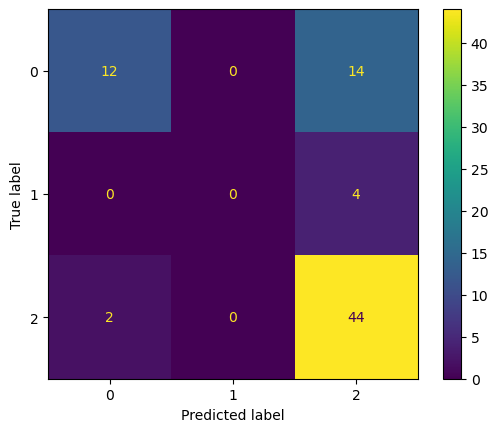

In [52]:
from torch.nn.functional import log_softmax
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_test = best_model['data']['Pheno_og_test']
res = torch.Tensor(best_model['data']['sev_scores_test'])
preds = torch.exp(log_softmax(res,dim=1)).max(dim=1)[1]
cm = confusion_matrix(y_test, preds, labels=[0,1,2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0,1,2])
disp.plot()

### Find patients severity score and values for top-k salient features

In [22]:
best_model_sevscore = best_model['data']['sev_scores_test']
best_model_pat_idxs = best_model['data']['ids_out_test']

In [23]:
torch.nn.functional.softmax(torch.Tensor(best_model_sevscore[rand_pat]), dim=0)

tensor([0.1911, 0.0863, 0.7226])

In [24]:
best_model_pat_idxs[rand_pat]

4657.0

In [25]:
clin_dat_pat = clin_dat_bl_x.loc[str(int(best_model_pat_idxs[rand_pat]))]
clin_dat_pat - clin_dat_bl_x.mean().round(3)

RAVLT_immediate          -23.522000
RAVLT_learning            -0.424000
RAVLT_forgetting          -2.218000
RAVLT_perc_forgetting     -5.293000
LDELTOTAL                 -4.754000
DIGITSCOR                  0.000398
TRABSCOR                 144.587000
dtype: float64

In [26]:
(clin_dat_pat/ clin_dat_bl_x.std()).round(0)

RAVLT_immediate          1.0
RAVLT_learning           1.0
RAVLT_forgetting         1.0
RAVLT_perc_forgetting    1.0
LDELTOTAL                1.0
DIGITSCOR                5.0
TRABSCOR                 4.0
dtype: float64

In [27]:
img_data_pat = img_data.loc[str(int(best_model_pat_idxs[rand_pat]))]
img_data_pat_diff = img_data_pat.astype('float') - img_data.astype('float').mean().round(3)
img_data_pat_diff.loc[['RPope', 'RRAC','RInfTemporal','LMedOrbit']]

RPope            115.142
RPope             53.983
RPope             -0.115
RPope             -0.070
RRAC             334.060
RRAC             159.927
RRAC              -0.039
RRAC              -0.018
RInfTemporal   -3670.165
RInfTemporal    -957.678
RInfTemporal      -0.221
RInfTemporal      -0.118
LMedOrbit        291.426
LMedOrbit        269.291
LMedOrbit         -0.106
LMedOrbit         -0.153
dtype: float64

In [28]:
(img_data_pat.astype('float') / img_data.astype('float').std()).round(0).loc[['RPope', 'RRAC','RInfTemporal','LMedOrbit']]

RPope            5.0
RPope            6.0
RPope           12.0
RPope            7.0
RRAC             5.0
RRAC             5.0
RRAC            10.0
RRAC             5.0
RInfTemporal     3.0
RInfTemporal     4.0
RInfTemporal    11.0
RInfTemporal     8.0
LMedOrbit        5.0
LMedOrbit        6.0
LMedOrbit       11.0
LMedOrbit        6.0
dtype: float64

In [29]:
### pat 2 
rand_pat = 1
k=10
clin_grads = best_model_attributions[0][rand_pat]
img_grads = best_model_attributions[1][rand_pat].flatten()
gen_grads = best_model_attributions[2][rand_pat].flatten()

all = torch.cat((clin_grads, img_grads, gen_grads), dim=0)
_, topf_idx = torch.topk(all.abs(),k)
print(torch.nn.functional.softmax(torch.Tensor(best_model_sevscore[rand_pat]), dim=0))
print(best_model_pat_idxs[rand_pat])

tensor([0.1911, 0.0863, 0.7226])
4657.0


In [30]:
pd.DataFrame(zip(all_feat_names[topf_idx.detach().cpu().numpy()],all[topf_idx].detach().cpu().numpy()),columns=['Feature','Attribution']).sort_values(by='Attribution')

,Feature,Attribution
0,RAVLT_immed,-0.223741
2,LDELTOTAL,-0.158018
3,RAVLT_forget,-0.134824
4,RAVLT_learn,-0.057594
5,DIGITSCOR,-0.057404
9,RIC_VOL,0.005377
8,RCuneus_CTA,0.005764
7,LPorb_CTA,0.006029
6,LFpole_CTA,0.006576
1,TRABSCOR,0.183464


In [31]:
clin_dat_pat = clin_dat_bl_x.loc[str(int(best_model_pat_idxs[rand_pat]))]
clin_dat_pat - clin_dat_bl_x.mean().round(3)

RAVLT_immediate          -23.522000
RAVLT_learning            -0.424000
RAVLT_forgetting          -2.218000
RAVLT_perc_forgetting     -5.293000
LDELTOTAL                 -4.754000
DIGITSCOR                  0.000398
TRABSCOR                 144.587000
dtype: float64

In [32]:
(clin_dat_pat/ clin_dat_bl_x.std()).round(0)

RAVLT_immediate          1.0
RAVLT_learning           1.0
RAVLT_forgetting         1.0
RAVLT_perc_forgetting    1.0
LDELTOTAL                1.0
DIGITSCOR                5.0
TRABSCOR                 4.0
dtype: float64

In [33]:
img_data.columns = np.apply_along_axis(lambda d: d[0] + '_' + d[1], 1, np.asarray(list(zip(np.repeat(img_feat,4),['CTA','CTSD','SA','VOL']*len(img_feat)))))
img_data_pat = img_data.loc[str(int(best_model_pat_idxs[rand_pat]))]
img_data_pat_diff = img_data_pat.astype('float') - img_data.astype('float').mean().round(3)
img_data_pat_diff.loc[['RIC_VOL', 'RCuneus_CTA','LPorb_CTA','LFpole_CTA']]

RIC_VOL          -0.103
RCuneus_CTA      22.933
LPorb_CTA      -471.000
LFpole_CTA    -1639.586
dtype: float64

In [34]:
(img_data_pat.astype('float') / img_data.astype('float').std()).round(0).loc[['RIC_VOL', 'RCuneus_CTA','LPorb_CTA','LFpole_CTA']]

RIC_VOL        5.0
RCuneus_CTA    6.0
LPorb_CTA      6.0
LFpole_CTA     5.0
dtype: float64

In [35]:
### pat 3
rand_pat = 27
k=10
clin_grads = best_model_attributions[0][rand_pat]
img_grads = best_model_attributions[1][rand_pat].flatten()
gen_grads = best_model_attributions[2][rand_pat].flatten()

all = torch.cat((clin_grads, img_grads, gen_grads), dim=0)
_, topf_idx = torch.topk(all.abs(),k)
print(torch.nn.functional.softmax(torch.Tensor(best_model_sevscore[rand_pat]), dim=0))
print(best_model_pat_idxs[rand_pat])

tensor([0.5310, 0.0799, 0.3891])
1249.0


In [36]:
pd.DataFrame(zip(all_feat_names[topf_idx.detach().cpu().numpy()],all[topf_idx].detach().cpu().numpy()),columns=['Feature','Attribution']).sort_values(by='Attribution')

,Feature,Attribution
4,TRABSCOR,-0.082519
9,LPorb_CTA,-0.005392
8,RPT_CTSD,0.005793
7,RRAC_CTA,0.006913
6,DIGITSCOR,0.015146
5,RAVLT_pforget,0.025046
3,RAVLT_immed,0.084306
2,LDELTOTAL,0.109818
1,RAVLT_forget,0.122818
0,RAVLT_learn,0.126077


In [126]:
clin_dat_pat = clin_dat_bl_x.loc[str(int(best_model_pat_idxs[rand_pat]))]
clin_dat_pat - clin_dat_bl_x.mean().round(3)

RAVLT_immediate          10.4780
RAVLT_learning            4.5760
RAVLT_forgetting          3.7820
RAVLT_perc_forgetting     1.8499
LDELTOTAL                 6.2460
DIGITSCOR                 2.9660
TRABSCOR                -54.4130
dtype: float64

In [128]:
img_data.columns = np.apply_along_axis(lambda d: d[0] + '_' + d[1], 1, np.asarray(list(zip(np.repeat(img_feat,4),['CTA','CTSD','SA','VOL']*len(img_feat)))))
img_data_pat = img_data.loc[str(int(best_model_pat_idxs[rand_pat]))]
img_data_pat_diff = img_data_pat.astype('float') - img_data.astype('float').mean().round(3)
img_data_pat_diff.loc[['LPorb_CTA', 'RPT_CTSD','RRAC_CTA']]

LPorb_CTA   -1392.000
RPT_CTSD      204.913
RRAC_CTA    -2575.956
dtype: float64

In [ ]:
# Prompt building
prompt = f"A patient has an overall risk score of {0.7226}, in the range of 0 to 1, of having Alzheimer's disease.\
    A multimodal deep learning model has attributed the high risk of Alzheimer’s disease to several salient features.\
    First, the volume of the right insula with an attribution of {0.005377}, and cortical average thickness of the\
    right cuneus (attribution of {0.005764}), the left pars orbitalis (attribution of {0.006029}), and left frontal pole\
    (attribution of {0.006576}), trails making test B (attribution of {0.183464}), Rey Auditory Verbal Learning test (attribution of 0.057594),\
    digit symbol substitution test (attribution of {0.057404}), and the logical memory - delayed test (attribution of {0.158018}).\
    The patient has a volume of the right insula {5} standard deviations lower than the general population.\
    A {6} standard deviations higher cortical average thickness of the right cuneus, {6} standard deviations\
    lower cortical average thickness of the left pars orbitalis, and {5} standard deviations lower left frontal pole compared to the general population.\
    The patient scored {4} standard deviation higher in the Trails making test B compared to the general population.\
    The patient scored {1} standard deviations lower in the Rey Auditory Verbal Learning test, {5} standard deviations lower digit symbol substitution test,\
    and {1} standard deviation the logical memory - delayed test compared to the general population. Explain how the salient features relate to one another\
    and how they relate to the higher risk of having Alzheimer’s disease. If any of those features is irrelevant to AD, please point it out."


In [ ]:
prompt = f"A patient has an overall risk score of {ad_risk}, in the range of 0 to 1, of having Alzheimer's disease. \
    A multimodal deep learning model has attributed the high risk of Alzheimer’s disease to several salient features. \
    First, the {f1_name} with an attribution of {f1_atr}, and {f2_name} \
    (attribution of {f2_atr}), the {f3_name} (attribution of {f3_atr}), and {f4_name} \
    (attribution of {f4_atr}), {f5_name} (attribution of {f5_atr}), {f6_name} (attribution of {f6_atr}), \
    {f7_name} (attribution of {f7_atr}), and {f8_name} (attribution of {f8_atr}). \
    The patient has a {f1_name} {f1_sd} standard deviations {f1_hilo} than the general population. \
    A {f2_sd} standard deviations {f2_hilo} {f2_name}, {f3_sd} standard deviations \
    {f3_hilo} {f3_name}, and {f4_sd} standard deviations {f4_hilo} {f4_name} compared to the general population. \
    The patient scored {f5_sd} standard deviation {f5_hilo} in the {f5_name} compared to the general population. \
    The patient scored {f6_sd} standard deviations {f6_hilo} in the {f6_name}, {f7_sd} standard deviations {f7_hilo} {f7_name}, \
    and {f8_sd} standard deviation {f8_hilo} the {f8_name} compared to the general population. Explain how the salient features relate to one another \
    and how they relate to the higher risk of having Alzheimer’s disease. If any of those features is irrelevant to AD, please point it out."

In [73]:
def hilo(diff):
    if diff >0:
        return 'higher'
    else:
        return 'lower' 

clin_name_dict = {
    'RAVLT_immediate':'Rey auditory verbal learning immediate test',
    'RAVLT_learning':'Rey auditory verbal learning test',
    'RAVLT_forgetting':'Rey auditory verbal learning forgetting test',
    'RAVLT_perc_forgetting':'Rey auditory verbal learning percent forgetting test',
    'LDELTOTAL':'Logical Memory - Delayed Recall',
    'DIGITSCOR':'Digit Symbol Substitution',
    'TRABSCOR':'Trail Making Test B',
}   
img_name_dict = {
    'LBankssts': 'Left Cortical areas around superior temporal sulcus',
    'LCAC': 'Left Caudal Anterior Cingulate',
    'LCMF': 'Left Caudal Middle Frontal',
    'LCC': 'Left Corpus Callosum',
    'LCuneus': 'Left Cuneus cortex',
    'LEntorhinal': 'Left Entorhinal cortex',
    'LFpole': 'Left Frontal Pole',
    'LFusiform': 'Left Fusiform gyrus',
    'LInfParietal': 'Left Inferior Parietal lobe',
    'LInfTemporal': 'Left Inferior Temporal gyrus',
    'LInsula': 'Left Insula',
    'LIC': 'Left Isthmus Cingulate cortex',
    'LLatOcc': 'Left Lateral Occipital cortex',
    'LLatOrbit': 'Left Lateral Orbitofrontal cortex',
    'LLingual': 'Left Lingual gyrus',
    'LMedOrbit': 'Left Medial Orbital frontal cortex',
    'LMidTemporal': 'Left Middle Temporal gyrus',
    'LParacentral': 'Left Paracentral lobule',
    'LPH': 'Left Parahippocampal gyrus',
    'LPope': 'Left Pars Opercularis',
    'LPorb': 'Left Pars Orbitalis',
    'LPT': 'Left Pars Triangularis',
    'LPC': 'Left Pericalcarine cortex',
    'LPostCentral': 'Left Postcentral gyrus',
    'LPostCing': 'Left Posterior Cingulate cortex',
    'LPrecentral': 'Left Precentral gyrus',
    'LPrecuneus': 'Left Precuneus cortex',
    'LRAC': 'Left Rostral Anterior Cingulate cortex',
    'LRMF': 'Left Rostral Middle Frontal gyrus',
    'LSF': 'Left Superior Frontal gyrus',
    'LSP': 'Left Superior Parietal gyrus',
    'LST': 'Left Superior Temporal gyrus',
    'LSMarg': 'Left Supramarginal gyrus',
    'LTempPole': 'Left Temporal Pole',
    'LTransTemp': 'Left Transverse Temporal cortex',
    'RBankssts': 'Right Cortical areas around superior temporal sulcus',
    'RCAC': 'Right Caudal Anterior Cingulate',
    'RCMF': 'Right Caudal Middle Frontal',
    'RCC': 'Right Corpus Callosum',
    'RCuneus': 'Right Cuneus cortex',
    'REntorhinal': 'Right Entorhinal cortex',
    'RFpole': 'Right Frontal Pole',
    'RFusiform': 'Right Fusiform gyrus',
    'RInfParietal': 'Right Inferior Parietal lobe',
    'RInfTemporal': 'Right Inferior Temporal gyrus',
    'RInsula': 'Right Insula',
    'RIC': 'Right Isthmus Cingulate cortex',
    'RLatOcc': 'Right Lateral Occipital cortex',
    'RLatOrbit': 'Right Lateral Orbitofrontal cortex',
    'RLingual': 'Right Lingual gyrus',
    'RMedOrbit': 'Right Medial Orbital frontal cortex',
    'RMidTemporal': 'Right Middle Temporal gyrus',
    'RParacentral':'Right Paracentral lobule',
    'RPH':'Right Parahippocampal gyrus',
    'RPope':'Right Pars Opercularis',
    'RPorb':'Right Pars Orbitalis',
    'RPT':'Right Pars Triangularis',
    'RPC':'Right Pericalcarine cortex',
    'RPostCentral':'Right Postcentral gyrus',
    'RPostCing':'Right Posterior Cingulate cortex',
    'RPrecentral':'Right Precentral gyrus',
    'RPrecuneus':'Right Precuneus cortex',
    'RRAC':'Right Rostral Anterior Cingulate cortex',
    'RRMF':'Right Rostral Middle Frontal gyrus',
    'RSF':'Right Superior Frontal gyrus',
    'RSP':'Right Superior Parietal gyrus',
    'RST':'Right Superior Temporal gyrus',
    'RSMarg':'Right Supramarginal gyrus',
    'RTempPole':'Right Temporal Pole',
    'RTransTemp':'Right Transverse Temporal cortex',
}
struct_name_dict = {
    'CTA':'average cortical thickness',
    'CTS': 'standard deviation cortical thickness',
    'SA':'surface area',
    'VOL':'volume'
    
}

In [78]:
def calc_pat_feats(pat_num,k,best_model_attributions,best_model_sevscore,best_model_pat_idxs,all_feat_names,clin_dat_bl_x):
    clin_grads = best_model_attributions[0][pat_num]
    img_grads = best_model_attributions[1][pat_num].flatten()
    gen_grads = best_model_attributions[2][pat_num].flatten()

    all = torch.cat((clin_grads, img_grads, gen_grads), dim=0)
    _, topf_idx = torch.topk(all.abs(),k)
    print(torch.nn.functional.softmax(torch.Tensor(best_model_sevscore[pat_num]), dim=0))
    print(best_model_pat_idxs[pat_num])

    salient_feats = pd.DataFrame(zip(all_feat_names[topf_idx.detach().cpu().numpy()],all[topf_idx].detach().cpu().numpy()),columns=['Feature','Attribution']).sort_values(by='Attribution')
    clin_dat_pat = clin_dat_bl_x.loc[str(int(best_model_pat_idxs[rand_pat]))]
    raw_pat_diff_clin = clin_dat_pat - clin_dat_bl_x.mean().round(3)
    sd_pat_clin = (clin_dat_pat/ clin_dat_bl_x.std()).round(0)
    img_data.columns = np.apply_along_axis(lambda d: d[0] + '_' + d[1], 1, np.asarray(list(zip(np.repeat(img_feat,4),['CTA','CTSD','SA','VOL']*len(img_feat)))))
    img_data_pat = img_data.loc[str(int(best_model_pat_idxs[rand_pat]))]
    img_data_pat_diff = img_data_pat.astype('float') - img_data.astype('float').mean().round(3)
    raw_pat_diff_img = img_data_pat_diff.loc[['RIC_VOL', 'RCuneus_CTA','LPorb_CTA','LFpole_CTA']]
    sd_pat_img = (img_data_pat.astype('float') / img_data.astype('float').std()).round(0).loc[['RIC_VOL', 'RCuneus_CTA','LPorb_CTA','LFpole_CTA']]

    sd_pat_clin.index = sd_pat_clin.index.map(clin_name_dict)
    # sd_pat_img.index = sd_pat_img.index.map(img_name_dict)
    sd_pat_img['roi'] = sd_pat_img.index.str.split('_').str[0].map(img_name_dict)
    sd_pat_img['struct'] = sd_pat_img.index.str.split('_').str[1].map(struct_name_dict)

    ad_risk = torch.nn.functional.softmax(torch.Tensor(best_model_sevscore[pat_num]), dim=0)[-1]
    print(sd_pat_img)
    f1_name, f1_atr, f1_hilo, f1_sd = sd_pat_img[0,0],salient_feats.loc[salient_feats['Feature']==sd_pat_img[0,0],'Attribution'],hilo(raw_pat_diff_img[0,1]),sd_pat_img[0,1]
    f2_name, f2_atr, f2_hilo, f2_sd = sd_pat_img[1,0],salient_feats.loc[salient_feats['Feature']==sd_pat_img[1,0],'Attribution'],hilo(raw_pat_diff_img[1,1]),sd_pat_img[1,1]
    f3_name, f3_atr, f3_hilo, f3_sd = sd_pat_img[2,0],salient_feats.loc[salient_feats['Feature']==sd_pat_img[2,0],'Attribution'],hilo(raw_pat_diff_img[2,1]),sd_pat_img[2,1]
    f4_name, f4_atr, f4_hilo, f4_sd = sd_pat_img[3,0],salient_feats.loc[salient_feats['Feature']==sd_pat_img[3,0],'Attribution'],hilo(raw_pat_diff_img[3,1]),sd_pat_img[3,1]
    f5_name, f5_atr, f5_hilo, f5_sd = sd_pat_img[4,0],salient_feats.loc[salient_feats['Feature']==sd_pat_img[4,0],'Attribution'],hilo(raw_pat_diff_img[4,1]),sd_pat_img[4,1]
    f6_name, f6_atr, f6_hilo, f6_sd = sd_pat_img[5,0],salient_feats.loc[salient_feats['Feature']==sd_pat_img[5,0],'Attribution'],hilo(raw_pat_diff_img[5,1]),sd_pat_img[5,1]
    f7_name, f7_atr, f7_hilo, f7_sd = sd_pat_img[6,0],salient_feats.loc[salient_feats['Feature']==sd_pat_img[6,0],'Attribution'],hilo(raw_pat_diff_img[6,1]),sd_pat_img[6,1]
    f8_name, f8_atr, f8_hilo, f8_sd = sd_pat_img[7,0],salient_feats.loc[salient_feats['Feature']==sd_pat_img[7,0],'Attribution'],hilo(raw_pat_diff_img[7,1]),sd_pat_img[7,1]


    prompt = f"A patient has an overall risk score of {ad_risk}, in the range of 0 to 1, of having Alzheimer's disease. \
    A multimodal deep learning model has attributed the high risk of Alzheimer’s disease to several salient features. \
    First, the {f1_name} with an attribution of {f1_atr}, and {f2_name} \
    (attribution of {f2_atr}), the {f3_name} (attribution of {f3_atr}), and {f4_name} \
    (attribution of {f4_atr}), {f5_name} (attribution of {f5_atr}), {f6_name} (attribution of {f6_atr}), \
    {f7_name} (attribution of {f7_atr}), and {f8_name} (attribution of {f8_atr}). \
    The patient has a {f1_name} {f1_sd} standard deviations {f1_hilo} than the general population. \
    A {f2_sd} standard deviations {f2_hilo} {f2_name}, {f3_sd} standard deviations \
    {f3_hilo} {f3_name}, and {f4_sd} standard deviations {f4_hilo} {f4_name} compared to the general population. \
    The patient scored {f5_sd} standard deviation {f5_hilo} in the {f5_name} compared to the general population. \
    The patient scored {f6_sd} standard deviations {f6_hilo} in the {f6_name}, {f7_sd} standard deviations {f7_hilo} {f7_name}, \
    and {f8_sd} standard deviation {f8_hilo} the {f8_name} compared to the general population. Explain how the salient features relate to one another \
    and how they relate to the higher risk of having Alzheimer’s disease. If any of those features is irrelevant to AD, please point it out."

    print(prompt)

In [96]:
pat_num = 0
clin_grads = best_model_attributions[0][pat_num]
img_grads = best_model_attributions[1][pat_num].flatten()
gen_grads = best_model_attributions[2][pat_num].flatten()

all = torch.cat((clin_grads, img_grads, gen_grads), dim=0)
_, topf_idx = torch.topk(all.abs(),k)
print(torch.nn.functional.softmax(torch.Tensor(best_model_sevscore[pat_num]), dim=0))
print(best_model_pat_idxs[pat_num])

salient_feats = pd.DataFrame(zip(all_feat_names[topf_idx.detach().cpu().numpy()],all[topf_idx].detach().cpu().numpy()),columns=['Feature','Attribution']).sort_values(by='Attribution')
clin_dat_pat = clin_dat_bl_x.loc[str(int(best_model_pat_idxs[rand_pat]))]
raw_pat_diff_clin = clin_dat_pat - clin_dat_bl_x.mean().round(3)
sd_pat_clin = (clin_dat_pat/ clin_dat_bl_x.std()).round(0)
img_data.columns = np.apply_along_axis(lambda d: d[0] + '_' + d[1], 1, np.asarray(list(zip(np.repeat(img_feat,4),['CTA','CTSD','SA','VOL']*len(img_feat)))))
img_data_pat = img_data.loc[str(int(best_model_pat_idxs[rand_pat]))]
img_data_pat_diff = img_data_pat.astype('float') - img_data.astype('float').mean().round(3)
raw_pat_diff_img = img_data_pat_diff.loc[['RIC_VOL', 'RCuneus_CTA','LPorb_CTA','LFpole_CTA']]
sd_pat_img = (img_data_pat.astype('float') / img_data.astype('float').std()).round(0).loc[['RIC_VOL', 'RCuneus_CTA','LPorb_CTA','LFpole_CTA']]

sd_pat_clin.index = sd_pat_clin.index.map(clin_name_dict)
sd_pat_img.index = pd.Series(sd_pat_img.index.str.split('_').str[1].map(struct_name_dict) +' of the ' + sd_pat_img.index.str.split('_').str[0].map(img_name_dict))
# sd_pat_img['roi'] = sd_pat_img.index.str.split('_').str[0].map(img_name_dict)
# sd_pat_img['struct'] = sd_pat_img.index.str.split('_').str[1].map(struct_name_dict)

ad_risk = torch.nn.functional.softmax(torch.Tensor(best_model_sevscore[pat_num]), dim=0)[-1]
print(sd_pat_img)
f1_name, f1_atr, f1_hilo, f1_sd = sd_pat_img.index[0],salient_feats.loc[salient_feats['Feature']==sd_pat_img.index[0],'Attribution'],hilo(raw_pat_diff_img[0]),sd_pat_img[0]
f2_name, f2_atr, f2_hilo, f2_sd = sd_pat_img.index[1],salient_feats.loc[salient_feats['Feature']==sd_pat_img.index[1],'Attribution'],hilo(raw_pat_diff_img[1]),sd_pat_img[1]
f3_name, f3_atr, f3_hilo, f3_sd = sd_pat_img.index[2],salient_feats.loc[salient_feats['Feature']==sd_pat_img.index[2],'Attribution'],hilo(raw_pat_diff_img[2]),sd_pat_img[2]
f4_name, f4_atr, f4_hilo, f4_sd = sd_pat_img.index[3],salient_feats.loc[salient_feats['Feature']==sd_pat_img.index[3],'Attribution'],hilo(raw_pat_diff_img[3]),sd_pat_img[3]
f5_name, f5_atr, f5_hilo, f5_sd = sd_pat_img.index[4],salient_feats.loc[salient_feats['Feature']==sd_pat_img.index[4],'Attribution'],hilo(raw_pat_diff_img[4]),sd_pat_img[4]
f6_name, f6_atr, f6_hilo, f6_sd = sd_pat_img.index[5],salient_feats.loc[salient_feats['Feature']==sd_pat_img.index[5],'Attribution'],hilo(raw_pat_diff_img[5]),sd_pat_img[5]
f7_name, f7_atr, f7_hilo, f7_sd = sd_pat_img.index[6],salient_feats.loc[salient_feats['Feature']==sd_pat_img.index[6],'Attribution'],hilo(raw_pat_diff_img[6]),sd_pat_img[6]
f8_name, f8_atr, f8_hilo, f8_sd = sd_pat_img.index[7],salient_feats.loc[salient_feats['Feature']==sd_pat_img.index[7],'Attribution'],hilo(raw_pat_diff_img[7]),sd_pat_img[7]

tensor([0.3532, 0.0666, 0.5803])
802.0
volume of the Right Isthmus Cingulate cortex             5.0
average cortical thickness of the Right Cuneus cortex    3.0
average cortical thickness of the Left Pars Orbitalis    5.0
average cortical thickness of the Left Frontal Pole      6.0
dtype: float64


IndexError: index 4 is out of bounds for axis 0 with size 4

In [95]:
sd_pat_img[0]

5.0

In [79]:
calc_pat_feats(0,10,best_model_attributions,best_model_sevscore,best_model_pat_idxs,all_feat_names,clin_dat_bl_x)

tensor([0.3532, 0.0666, 0.5803])
802.0
RIC_VOL                                                      5.0
RCuneus_CTA                                                  3.0
LPorb_CTA                                                    5.0
LFpole_CTA                                                   6.0
roi            Index(['Right Isthmus Cingulate cortex', 'Righ...
struct         Index([                    'volume', 'average ...
dtype: object


KeyError: 'key of type tuple not found and not a MultiIndex'

In [ ]:
def prompt_build(blanks):
    ad_risk = blanks[]
    f1_name, f1_atr, f1_hilo, f1_sd = blanks['f1_name'],blanks[],blanks[],blanks[]
    f2_name, f2_atr, f2_hilo, f2_sd = blanks[],blanks[],blanks[],blanks[]
    f3_name, f3_atr, f3_hilo, f3_sd = blanks[],blanks[],blanks[],blanks[]
    f4_name, f4_atr, f4_hilo, f4_sd = blanks[],blanks[],blanks[],blanks[]
    f5_name, f5_atr, f5_hilo, f5_sd = blanks[],blanks[],blanks[],blanks[]
    f6_name, f6_atr, f6_hilo, f6_sd = blanks[],blanks[],blanks[],blanks[]
    f7_name, f7_atr, f7_hilo, f7_sd = blanks[],blanks[],blanks[],blanks[]
    f8_name, f8_atr, f8_hilo, f8_sd = blanks[],blanks[],blanks[],blanks[]
    prompt = f"A patient has an overall risk score of {ad_risk}, in the range of 0 to 1, of having Alzheimer's disease. \
    A multimodal deep learning model has attributed the high risk of Alzheimer’s disease to several salient features. \
    First, the {f1_name} with an attribution of {f1_atr}, and {f2_name} \
    (attribution of {f2_atr}), the {f3_name} (attribution of {f3_atr}), and {f4_name} \
    (attribution of {f4_atr}), {f5_name} (attribution of {f5_atr}), {f6_name} (attribution of {f6_atr}), \
    {f7_name} (attribution of {f7_atr}), and {f8_name} (attribution of {f8_atr}). \
    The patient has a {f1_name} {f1_sd} standard deviations {f1_hilo} than the general population. \
    A {f2_sd} standard deviations {f2_hilo} {f2_name}, {f3_sd} standard deviations \
    {f3_hilo} {f3_name}, and {f4_sd} standard deviations {f4_hilo} {f4_name} compared to the general population. \
    The patient scored {f5_sd} standard deviation {f5_hilo} in the {f5_name} compared to the general population. \
    The patient scored {f6_sd} standard deviations {f6_hilo} in the {f6_name}, {f7_sd} standard deviations {f7_hilo} {f7_name}, \
    and {f8_sd} standard deviation {f8_hilo} the {f8_name} compared to the general population. Explain how the salient features relate to one another \
    and how they relate to the higher risk of having Alzheimer’s disease. If any of those features is irrelevant to AD, please point it out."
    return prompt